<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CLAHE = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [32]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [33]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [34]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [35]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [36]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

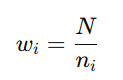

In [37]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [38]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [39]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [40]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [41]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [42]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.017
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [43]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [44]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [45]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'alexnetmulticlass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    # transforms.RandomGrayscale(p = 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = True
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': True}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.655395119076231
Accuracy train epoch: 1  train_acc: 0.52145961608113
F1 train epoch: 1  train_f1: 0.5728306932793692
Recall train epoch: 1  train_recall: 0.52145961608113


Pèrdua validació epoch: 1  val_loss: 1.3323748800903559
Accuracy val epoch: 1  val_acc: 0.60078125
F1 val epoch: 1  val_f1: 0.6477436490985103
Recall val epoch: 1  val_recall: 0.60078125
Recall val epoch: 1  val_precision: 0.7951267209129975


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.178505958670164
Accuracy train epoch: 2  train_acc: 0.6139193227091634
F1 train epoch: 2  train_f1: 0.6621815036204249
Recall train epoch: 2  train_recall: 0.6139193227091634


Pèrdua validació epoch: 2  val_loss: 1.0768993897363544
Accuracy val epoch: 2  val_acc: 0.6685546875
F1 val epoch: 2  val_f1: 0.7092765608757172
Recall val epoch: 2  val_recall: 0.6685546875
Recall val epoch: 2  val_precision: 0.8159676955006235


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.9929478396457505
Accuracy train epoch: 3  train_acc: 0.6504549981890618
F1 train epoch: 3  train_f1: 0.6944259308328881
Recall train epoch: 3  train_recall: 0.6504549981890618


Pèrdua validació epoch: 3  val_loss: 0.9943338483572006
Accuracy val epoch: 3  val_acc: 0.715625
F1 val epoch: 3  val_f1: 0.7480174416122496
Recall val epoch: 3  val_recall: 0.715625
Recall val epoch: 3  val_precision: 0.8318075571749776


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.8870567453216271
Accuracy train epoch: 4  train_acc: 0.673827417602318
F1 train epoch: 4  train_f1: 0.7154429466705629
Recall train epoch: 4  train_recall: 0.673827417602318


Pèrdua validació epoch: 4  val_loss: 0.9829915473237634
Accuracy val epoch: 4  val_acc: 0.683203125
F1 val epoch: 4  val_f1: 0.7236907667039423
Recall val epoch: 4  val_recall: 0.683203125
Recall val epoch: 4  val_precision: 0.8134923365775334


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.8191730461984992
Accuracy train epoch: 5  train_acc: 0.6870585838464324
F1 train epoch: 5  train_f1: 0.7252125126093846
Recall train epoch: 5  train_recall: 0.6870585838464324


Pèrdua validació epoch: 5  val_loss: 0.9677311014384031
Accuracy val epoch: 5  val_acc: 0.708203125
F1 val epoch: 5  val_f1: 0.7421684923241029
Recall val epoch: 5  val_recall: 0.708203125
Recall val epoch: 5  val_precision: 0.8320019756990447


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.761143661471477
Accuracy train epoch: 6  train_acc: 0.7064808946034045
F1 train epoch: 6  train_f1: 0.7408003410019016
Recall train epoch: 6  train_recall: 0.7064808946034045


Pèrdua validació epoch: 6  val_loss: 0.8971559470519423
Accuracy val epoch: 6  val_acc: 0.7169921875
F1 val epoch: 6  val_f1: 0.7550688644315243
Recall val epoch: 6  val_recall: 0.7169921875
Recall val epoch: 6  val_precision: 0.8396738146946697


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.7247783395042457
Accuracy train epoch: 7  train_acc: 0.7074429554509235
F1 train epoch: 7  train_f1: 0.7431517876617332
Recall train epoch: 7  train_recall: 0.7074429554509235


Pèrdua validació epoch: 7  val_loss: 0.8848602576181293
Accuracy val epoch: 7  val_acc: 0.72890625
F1 val epoch: 7  val_f1: 0.7629051302783916
Recall val epoch: 7  val_recall: 0.72890625
Recall val epoch: 7  val_precision: 0.8461291089412223


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.6881081176943988
Accuracy train epoch: 8  train_acc: 0.7151960340456356
F1 train epoch: 8  train_f1: 0.750722499719576
Recall train epoch: 8  train_recall: 0.7151960340456356


Pèrdua validació epoch: 8  val_loss: 0.829689159989357
Accuracy val epoch: 8  val_acc: 0.752734375
F1 val epoch: 8  val_f1: 0.7832132809436375
Recall val epoch: 8  val_recall: 0.752734375
Recall val epoch: 8  val_precision: 0.8617972463612491


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.6513461107870497
Accuracy train epoch: 9  train_acc: 0.7261522093444404
F1 train epoch: 9  train_f1: 0.7596712722971414
Recall train epoch: 9  train_recall: 0.7261522093444404


Pèrdua validació epoch: 9  val_loss: 0.8795981323346496
Accuracy val epoch: 9  val_acc: 0.716796875
F1 val epoch: 9  val_f1: 0.7478577529876776
Recall val epoch: 9  val_recall: 0.716796875
Recall val epoch: 9  val_precision: 0.8426022219422183


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.6055495043793523
Accuracy train epoch: 10  train_acc: 0.7351955813111192
F1 train epoch: 10  train_f1: 0.7670146624708465
Recall train epoch: 10  train_recall: 0.7351955813111192


Pèrdua validació epoch: 10  val_loss: 0.787747735157609
Accuracy val epoch: 10  val_acc: 0.7615234375
F1 val epoch: 10  val_f1: 0.784050234464255
Recall val epoch: 10  val_recall: 0.7615234375
Recall val epoch: 10  val_precision: 0.8570223748640204


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.5922501160210347
Accuracy train epoch: 11  train_acc: 0.7403114813473379
F1 train epoch: 11  train_f1: 0.7720253917243365
Recall train epoch: 11  train_recall: 0.7403114813473379


Pèrdua validació epoch: 11  val_loss: 0.812074105720967
Accuracy val epoch: 11  val_acc: 0.737109375
F1 val epoch: 11  val_f1: 0.7685455819979266
Recall val epoch: 11  val_recall: 0.737109375
Recall val epoch: 11  val_precision: 0.8429131494367306


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.5672124088166719
Accuracy train epoch: 12  train_acc: 0.7511318362911988
F1 train epoch: 12  train_f1: 0.7810802590953997
Recall train epoch: 12  train_recall: 0.7511318362911988


Pèrdua validació epoch: 12  val_loss: 0.7744559198617935
Accuracy val epoch: 12  val_acc: 0.7513671875
F1 val epoch: 12  val_f1: 0.7762315609993933
Recall val epoch: 12  val_recall: 0.7513671875
Recall val epoch: 12  val_precision: 0.8503995076399777


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.5403279468595269
Accuracy train epoch: 13  train_acc: 0.7563835566823615
F1 train epoch: 13  train_f1: 0.7851013190358529
Recall train epoch: 13  train_recall: 0.7563835566823615


Pèrdua validació epoch: 13  val_loss: 0.795528189279139
Accuracy val epoch: 13  val_acc: 0.76015625
F1 val epoch: 13  val_f1: 0.7862340736531753
Recall val epoch: 13  val_recall: 0.76015625
Recall val epoch: 13  val_precision: 0.8538655080877047


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.48860346706977403
Accuracy train epoch: 14  train_acc: 0.7739383375588554
F1 train epoch: 14  train_f1: 0.8002017406490456
Recall train epoch: 14  train_recall: 0.7739383375588554


Pèrdua validació epoch: 14  val_loss: 0.8204166004434228
Accuracy val epoch: 14  val_acc: 0.7544921875
F1 val epoch: 14  val_f1: 0.778064631021763
Recall val epoch: 14  val_recall: 0.7544921875
Recall val epoch: 14  val_precision: 0.8531325624849624


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.4914572665475279
Accuracy train epoch: 15  train_acc: 0.7740741579137993
F1 train epoch: 15  train_f1: 0.8005182499439939
Recall train epoch: 15  train_recall: 0.7740741579137993


Pèrdua validació epoch: 15  val_loss: 0.8427210347726941
Accuracy val epoch: 15  val_acc: 0.7435546875
F1 val epoch: 15  val_f1: 0.7707173825206527
Recall val epoch: 15  val_recall: 0.7435546875
Recall val epoch: 15  val_precision: 0.8494165940087658


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.4592477903363714
Accuracy train epoch: 16  train_acc: 0.7813971387178559
F1 train epoch: 16  train_f1: 0.8055366642732209
Recall train epoch: 16  train_recall: 0.7813971387178559


Pèrdua validació epoch: 16  val_loss: 0.8329542404972017
Accuracy val epoch: 16  val_acc: 0.783984375
F1 val epoch: 16  val_f1: 0.8030324317344599
Recall val epoch: 16  val_recall: 0.783984375
Recall val epoch: 16  val_precision: 0.862504565005079


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.44707695293830213
Accuracy train epoch: 17  train_acc: 0.7866262223831945
F1 train epoch: 17  train_f1: 0.8107446153009293
Recall train epoch: 17  train_recall: 0.7866262223831945


Pèrdua validació epoch: 17  val_loss: 0.8196442644111812
Accuracy val epoch: 17  val_acc: 0.7505859375
F1 val epoch: 17  val_f1: 0.7781228735623236
Recall val epoch: 17  val_recall: 0.7505859375
Recall val epoch: 17  val_precision: 0.8565536751619526


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.43761294219360886
Accuracy train epoch: 18  train_acc: 0.7902367801521187
F1 train epoch: 18  train_f1: 0.8156553972245834
Recall train epoch: 18  train_recall: 0.7902367801521187


Pèrdua validació epoch: 18  val_loss: 0.7977437363006175
Accuracy val epoch: 18  val_acc: 0.75546875
F1 val epoch: 18  val_f1: 0.7770240777490898
Recall val epoch: 18  val_recall: 0.75546875
Recall val epoch: 18  val_precision: 0.846245148464909


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.4256413637166954
Accuracy train epoch: 19  train_acc: 0.7933266932270916
F1 train epoch: 19  train_f1: 0.8170991505291161
Recall train epoch: 19  train_recall: 0.7933266932270916


Pèrdua validació epoch: 19  val_loss: 0.7305775105487555
Accuracy val epoch: 19  val_acc: 0.7591796875
F1 val epoch: 19  val_f1: 0.7869793211907665
Recall val epoch: 19  val_recall: 0.7591796875
Recall val epoch: 19  val_precision: 0.8613875146742754


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.41630507361485186
Accuracy train epoch: 20  train_acc: 0.7942321622600507
F1 train epoch: 20  train_f1: 0.817587790510977
Recall train epoch: 20  train_recall: 0.7942321622600507


Pèrdua validació epoch: 20  val_loss: 0.816508003976196
Accuracy val epoch: 20  val_acc: 0.783984375
F1 val epoch: 20  val_f1: 0.8010875775071283
Recall val epoch: 20  val_recall: 0.783984375
Recall val epoch: 20  val_precision: 0.8600636079042862


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.38171863098780945
Accuracy train epoch: 21  train_acc: 0.8038074972835929
F1 train epoch: 21  train_f1: 0.8259069466275365
Recall train epoch: 21  train_recall: 0.8038074972835929


Pèrdua validació epoch: 21  val_loss: 0.7123252572491765
Accuracy val epoch: 21  val_acc: 0.760546875
F1 val epoch: 21  val_f1: 0.7882879347764336
Recall val epoch: 21  val_recall: 0.760546875
Recall val epoch: 21  val_precision: 0.8610676915860205


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.4028493236913624
Accuracy train epoch: 22  train_acc: 0.8045431908728722
F1 train epoch: 22  train_f1: 0.8253103264975473
Recall train epoch: 22  train_recall: 0.8045431908728722


Pèrdua validació epoch: 22  val_loss: 0.7516851485706866
Accuracy val epoch: 22  val_acc: 0.790625
F1 val epoch: 22  val_f1: 0.8097164514927203
Recall val epoch: 22  val_recall: 0.790625
Recall val epoch: 22  val_precision: 0.8641564438305275


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.3588248523939178
Accuracy train epoch: 23  train_acc: 0.8163708801159
F1 train epoch: 23  train_f1: 0.8363993399309724
Recall train epoch: 23  train_recall: 0.8163708801159


Pèrdua validació epoch: 23  val_loss: 0.7116105027962476
Accuracy val epoch: 23  val_acc: 0.7939453125
F1 val epoch: 23  val_f1: 0.8117753789093461
Recall val epoch: 23  val_recall: 0.7939453125
Recall val epoch: 23  val_precision: 0.8716987536002615


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.336841670373284
Accuracy train epoch: 24  train_acc: 0.8185100507062658
F1 train epoch: 24  train_f1: 0.8384141376287103
Recall train epoch: 24  train_recall: 0.8185100507062658


Pèrdua validació epoch: 24  val_loss: 0.8201799499802291
Accuracy val epoch: 24  val_acc: 0.7640625
F1 val epoch: 24  val_f1: 0.7841238932403498
Recall val epoch: 24  val_recall: 0.7640625
Recall val epoch: 24  val_precision: 0.8557741907661935


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.3528028268114742
Accuracy train epoch: 25  train_acc: 0.8283117529880478
F1 train epoch: 25  train_f1: 0.8467122363253903
Recall train epoch: 25  train_recall: 0.8283117529880478


Pèrdua validació epoch: 25  val_loss: 0.80819599237293
Accuracy val epoch: 25  val_acc: 0.77890625
F1 val epoch: 25  val_f1: 0.8009881912047148
Recall val epoch: 25  val_recall: 0.77890625
Recall val epoch: 25  val_precision: 0.86297076104976


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.33353504308488263
Accuracy train epoch: 26  train_acc: 0.8302019195943499
F1 train epoch: 26  train_f1: 0.8486922764981064
Recall train epoch: 26  train_recall: 0.8302019195943499


Pèrdua validació epoch: 26  val_loss: 0.7401320047210902
Accuracy val epoch: 26  val_acc: 0.8044921875
F1 val epoch: 26  val_f1: 0.8241265912256488
Recall val epoch: 26  val_recall: 0.8044921875
Recall val epoch: 26  val_precision: 0.8814574029538714


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.32713157190863357
Accuracy train epoch: 27  train_acc: 0.8336879753712423
F1 train epoch: 27  train_f1: 0.8520594472152976
Recall train epoch: 27  train_recall: 0.8336879753712423


Pèrdua validació epoch: 27  val_loss: 0.8366065337322652
Accuracy val epoch: 27  val_acc: 0.7763671875
F1 val epoch: 27  val_f1: 0.7986208816284983
Recall val epoch: 27  val_recall: 0.7763671875
Recall val epoch: 27  val_precision: 0.8599485265263849


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.3065806965963299
Accuracy train epoch: 28  train_acc: 0.8332126041289387
F1 train epoch: 28  train_f1: 0.8517583582293298
Recall train epoch: 28  train_recall: 0.8332126041289387


Pèrdua validació epoch: 28  val_loss: 0.8300803485326469
Accuracy val epoch: 28  val_acc: 0.791796875
F1 val epoch: 28  val_f1: 0.8134995828504515
Recall val epoch: 28  val_recall: 0.791796875
Recall val epoch: 28  val_precision: 0.874332050777847


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.2762733890537722
Accuracy train epoch: 29  train_acc: 0.8412825968851865
F1 train epoch: 29  train_f1: 0.8578145137554222
Recall train epoch: 29  train_recall: 0.8412825968851865


Pèrdua validació epoch: 29  val_loss: 0.8758319665212184
Accuracy val epoch: 29  val_acc: 0.7794921875
F1 val epoch: 29  val_f1: 0.8036059741202944
Recall val epoch: 29  val_recall: 0.7794921875
Recall val epoch: 29  val_precision: 0.866606940565488


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.2699865765602465
Accuracy train epoch: 30  train_acc: 0.845753350235422
F1 train epoch: 30  train_f1: 0.86195290583219
Recall train epoch: 30  train_recall: 0.845753350235422


Pèrdua validació epoch: 30  val_loss: 0.7615861324593425
Accuracy val epoch: 30  val_acc: 0.7767578125
F1 val epoch: 30  val_f1: 0.7999459841688479
Recall val epoch: 30  val_recall: 0.7767578125
Recall val epoch: 30  val_precision: 0.8641509878795386


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.27171298702696406
Accuracy train epoch: 31  train_acc: 0.8491375407461065
F1 train epoch: 31  train_f1: 0.8650171543019365
Recall train epoch: 31  train_recall: 0.8491375407461065


Pèrdua validació epoch: 31  val_loss: 0.819355288753286
Accuracy val epoch: 31  val_acc: 0.7849609375
F1 val epoch: 31  val_f1: 0.8014975126653825
Recall val epoch: 31  val_recall: 0.7849609375
Recall val epoch: 31  val_precision: 0.8647349464907259


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.2735952382306179
Accuracy train epoch: 32  train_acc: 0.8512540746106483
F1 train epoch: 32  train_f1: 0.8671854068823375
Recall train epoch: 32  train_recall: 0.8512540746106483


Pèrdua validació epoch: 32  val_loss: 0.7432002620771527
Accuracy val epoch: 32  val_acc: 0.7966796875
F1 val epoch: 32  val_f1: 0.8158241803937999
Recall val epoch: 32  val_recall: 0.7966796875
Recall val epoch: 32  val_precision: 0.8733490343009793


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.2513816143827609
Accuracy train epoch: 33  train_acc: 0.8606030423759508
F1 train epoch: 33  train_f1: 0.8764585950758474
Recall train epoch: 33  train_recall: 0.8606030423759508


Pèrdua validació epoch: 33  val_loss: 0.9286010679788888
Accuracy val epoch: 33  val_acc: 0.798046875
F1 val epoch: 33  val_f1: 0.8154510240277476
Recall val epoch: 33  val_recall: 0.798046875
Recall val epoch: 33  val_precision: 0.8685033015258911


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.2264665725132621
Accuracy train epoch: 34  train_acc: 0.8655604853314016
F1 train epoch: 34  train_f1: 0.879737125234325
Recall train epoch: 34  train_recall: 0.8655604853314016


Pèrdua validació epoch: 34  val_loss: 0.8678832403384149
Accuracy val epoch: 34  val_acc: 0.7744140625
F1 val epoch: 34  val_f1: 0.8022100413755249
Recall val epoch: 34  val_recall: 0.7744140625
Recall val epoch: 34  val_precision: 0.8744487749277592


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.22826398523205305
Accuracy train epoch: 35  train_acc: 0.8650624773632741
F1 train epoch: 35  train_f1: 0.8789671659456215
Recall train epoch: 35  train_recall: 0.8650624773632741


Pèrdua validació epoch: 35  val_loss: 0.7765257409773767
Accuracy val epoch: 35  val_acc: 0.8033203125
F1 val epoch: 35  val_f1: 0.8194108124350551
Recall val epoch: 35  val_recall: 0.8033203125
Recall val epoch: 35  val_precision: 0.8802871179236019


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.2283819625636496
Accuracy train epoch: 36  train_acc: 0.8675638355668236
F1 train epoch: 36  train_f1: 0.8819187773615275
Recall train epoch: 36  train_recall: 0.8675638355668236


Pèrdua validació epoch: 36  val_loss: 0.888248807284981
Accuracy val epoch: 36  val_acc: 0.794921875
F1 val epoch: 36  val_f1: 0.8120234915467622
Recall val epoch: 36  val_recall: 0.794921875
Recall val epoch: 36  val_precision: 0.8689108879156862


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.22077449440837382
Accuracy train epoch: 37  train_acc: 0.8646776530242666
F1 train epoch: 37  train_f1: 0.8794123072438835
Recall train epoch: 37  train_recall: 0.8646776530242666


Pèrdua validació epoch: 37  val_loss: 0.9164320072159171
Accuracy val epoch: 37  val_acc: 0.7908203125
F1 val epoch: 37  val_f1: 0.8085943204728105
Recall val epoch: 37  val_recall: 0.7908203125
Recall val epoch: 37  val_precision: 0.8708990653054484


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.21629781845912516
Accuracy train epoch: 38  train_acc: 0.8714120789568996
F1 train epoch: 38  train_f1: 0.8841069015776364
Recall train epoch: 38  train_recall: 0.8714120789568996


Pèrdua validació epoch: 38  val_loss: 0.9133241260424256
Accuracy val epoch: 38  val_acc: 0.7984375
F1 val epoch: 38  val_f1: 0.820746874319157
Recall val epoch: 38  val_recall: 0.7984375
Recall val epoch: 38  val_precision: 0.8834866227878213


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.20809824913888575
Accuracy train epoch: 39  train_acc: 0.8742529880478087
F1 train epoch: 39  train_f1: 0.8873459065649913
Recall train epoch: 39  train_recall: 0.8742529880478087


Pèrdua validació epoch: 39  val_loss: 0.9127346586901695
Accuracy val epoch: 39  val_acc: 0.8025390625
F1 val epoch: 39  val_f1: 0.8236017072992525
Recall val epoch: 39  val_recall: 0.8025390625
Recall val epoch: 39  val_precision: 0.8793597455044643


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.20418556863479168
Accuracy train epoch: 40  train_acc: 0.8736644331763853
F1 train epoch: 40  train_f1: 0.8864355670535046
Recall train epoch: 40  train_recall: 0.8736644331763853


Pèrdua validació epoch: 40  val_loss: 1.0164366494864225
Accuracy val epoch: 40  val_acc: 0.8138671875
F1 val epoch: 40  val_f1: 0.8314809342270841
Recall val epoch: 40  val_recall: 0.8138671875
Recall val epoch: 40  val_precision: 0.887626217158406


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.19291151032237655
Accuracy train epoch: 41  train_acc: 0.8829794458529518
F1 train epoch: 41  train_f1: 0.8948378098033475
Recall train epoch: 41  train_recall: 0.8829794458529518


Pèrdua validació epoch: 41  val_loss: 0.9856825163587928
Accuracy val epoch: 41  val_acc: 0.819140625
F1 val epoch: 41  val_f1: 0.8311432693080184
Recall val epoch: 41  val_recall: 0.819140625
Recall val epoch: 41  val_precision: 0.8868106988863561


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.19573460261066597
Accuracy train epoch: 42  train_acc: 0.8787350597609562
F1 train epoch: 42  train_f1: 0.8906618268046714
Recall train epoch: 42  train_recall: 0.8787350597609562


Pèrdua validació epoch: 42  val_loss: 0.9483119715005159
Accuracy val epoch: 42  val_acc: 0.8267578125
F1 val epoch: 42  val_f1: 0.8361173411209922
Recall val epoch: 42  val_recall: 0.8267578125
Recall val epoch: 42  val_precision: 0.8841911677758326


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.19733504628933282
Accuracy train epoch: 43  train_acc: 0.891683266932271
F1 train epoch: 43  train_f1: 0.9022885657197345
Recall train epoch: 43  train_recall: 0.891683266932271


Pèrdua validació epoch: 43  val_loss: 0.9298479398712516
Accuracy val epoch: 43  val_acc: 0.8158203125
F1 val epoch: 43  val_f1: 0.8281941282299663
Recall val epoch: 43  val_recall: 0.8158203125
Recall val epoch: 43  val_precision: 0.8777534640158146


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.18641480448399764
Accuracy train epoch: 44  train_acc: 0.8868276892430279
F1 train epoch: 44  train_f1: 0.8988349184127419
Recall train epoch: 44  train_recall: 0.8868276892430279


Pèrdua validació epoch: 44  val_loss: 0.9369427599012852
Accuracy val epoch: 44  val_acc: 0.812109375
F1 val epoch: 44  val_f1: 0.8251278213478627
Recall val epoch: 44  val_recall: 0.812109375
Recall val epoch: 44  val_precision: 0.8766947532582587


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.1805895315668735
Accuracy train epoch: 45  train_acc: 0.8898157370517928
F1 train epoch: 45  train_f1: 0.8993373270714347
Recall train epoch: 45  train_recall: 0.8898157370517928


Pèrdua validació epoch: 45  val_loss: 0.9577929184306413
Accuracy val epoch: 45  val_acc: 0.7890625
F1 val epoch: 45  val_f1: 0.8067900386073689
Recall val epoch: 45  val_recall: 0.7890625
Recall val epoch: 45  val_precision: 0.8744355908587498


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.16111818117004229
Accuracy train epoch: 46  train_acc: 0.898417692864904
F1 train epoch: 46  train_f1: 0.9091452064220403
Recall train epoch: 46  train_recall: 0.898417692864904


Pèrdua validació epoch: 46  val_loss: 0.8920263457112014
Accuracy val epoch: 46  val_acc: 0.804296875
F1 val epoch: 46  val_f1: 0.8260769292614987
Recall val epoch: 46  val_recall: 0.804296875
Recall val epoch: 46  val_precision: 0.8903453600090353


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.16782643773641245
Accuracy train epoch: 47  train_acc: 0.8985648315827598
F1 train epoch: 47  train_f1: 0.907704533459877
Recall train epoch: 47  train_recall: 0.8985648315827598


Pèrdua validació epoch: 47  val_loss: 0.9964624447748065
Accuracy val epoch: 47  val_acc: 0.8123046875
F1 val epoch: 47  val_f1: 0.8289588302865305
Recall val epoch: 47  val_recall: 0.8123046875
Recall val epoch: 47  val_precision: 0.8819594142720696


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.16885318462384413
Accuracy train epoch: 48  train_acc: 0.8986893335747917
F1 train epoch: 48  train_f1: 0.9093449712467694
Recall train epoch: 48  train_recall: 0.8986893335747917


Pèrdua validació epoch: 48  val_loss: 1.0645221786107868
Accuracy val epoch: 48  val_acc: 0.8201171875
F1 val epoch: 48  val_f1: 0.8315607647274805
Recall val epoch: 48  val_recall: 0.8201171875
Recall val epoch: 48  val_precision: 0.8844069394385794


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.16209514137817568
Accuracy train epoch: 49  train_acc: 0.8990288844621513
F1 train epoch: 49  train_f1: 0.9085711209523089
Recall train epoch: 49  train_recall: 0.8990288844621513


Pèrdua validació epoch: 49  val_loss: 0.8952629715204239
Accuracy val epoch: 49  val_acc: 0.8279296875
F1 val epoch: 49  val_f1: 0.8407033264620186
Recall val epoch: 49  val_recall: 0.8279296875
Recall val epoch: 49  val_precision: 0.8873597707201196


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.16672935135721922
Accuracy train epoch: 50  train_acc: 0.8991533864541833
F1 train epoch: 50  train_f1: 0.9096753136376282
Recall train epoch: 50  train_recall: 0.8991533864541833


Pèrdua validació epoch: 50  val_loss: 1.0550358896143734
Accuracy val epoch: 50  val_acc: 0.82578125
F1 val epoch: 50  val_f1: 0.8393544127154019
Recall val epoch: 50  val_recall: 0.82578125
Recall val epoch: 50  val_precision: 0.8848957355451943
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-43-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train/train_f1,▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
train/train_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇████████
train/train_recall,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val/val_acc,▁▃▅▄▄▅▆▅▆▅▆▆▅▇▆▇▆▇▇▆▇▆▇▆▇▇▆▇▇▇▇████▇▇███
val/val_f1,▁▃▅▄▄▅▆▅▆▅▆▆▅▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███
val/val_loss,█▅▄▄▄▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▃▂▁▃▃▂▃▃▄▄▄▃▄▃▄▅▅
val/val_precision,▁▃▄▂▄▅▆▄▆▅▅▅▅▆▆▆▆▆▇▅▇▆▇▆▆▇▆▇▇▆▇▇██▇▇█▇██
val/val_recall,▁▃▅▄▄▅▆▅▆▅▆▆▅▆▆▇▆▇▇▆▆▇▇▆▇▇▆▇▇▇▇████▇▇███
train/train_acc,0.89915
